# Kaggle competition : INGV - Volcanic Eruption Prediction 

## Introduction

This notebook summarizes the steps I followed for my submission to the INGV Kaggle competition, with which I achieved a top 25% position in the final ranking.
I mainly compared tree ensembling methods and neural networks.

The main problem of the competition is the following : we have a sample consisting of a great number of volcanoes. Ten sensors are disposed around each volcano.
Each sensor records the seismic activity on a given period of time. For each volcano, we thus have a matrix of ten columns, each one being a time series corresponding
to the activity recorded by the volcano. We also have the remaining time before next eruption. Using the ten time series, we aim at predicting the remaining time before
next eruption. The metric used for evaluation is the mean absolute error (MAE).
For more information, see here : https://www.kaggle.com/c/predict-volcanic-eruptions-ingv-oe/overview

To run the code below, don't forget to download the files attached with this notebook (X.csv and Y.csv) and place them in a clearly identified
directory. Then, change the paths to these files accordingly in the script.

## Preprocessing

Machine learning algorithms cannot be straightforwardly applied on the given data. We first have to perform some feature extraction. Three functions are introduced below :

- ListFiles: this function takes as argument a directory and lists all the csv files present in this directory. 
  It then returns a list containing all csv corresponding to volcanoes, a list containing the id's of the volcanoes 
  and a DataFrame corresponding to the train.csv file.
- FeatureExtraction: this function takes as argument a DataFrame containing sensor data, and extracts features from it. 
  We aim at summarizing efficiently the information contained in the sensor data. The extracted features are namely 
  the mean, standard deviation, max, quantiles, skewness and kurtosis of each sensor. The positions of the 
  maximum and minimum values are also extracted.
- ImportData: this function takes as arguments a directory containing the csv files corresponding to each volcano, and 
  the file containing the response variable. It then performs the extraction of features on each csv files corresponding 
  to a volcano. It finally returns a DataFrame containing the extracted features for each volcano, and another 
  DataFrame containing the id's and the remaining time to eruption (the response variable).

In [1]:
import pandas as pd
import numpy as np
import os

def ListFiles(path):
    listfiles = []
    id = []
    for root, dir, files in os.walk(path):
        for x in files:
            listfiles.append(os.path.join(root, x))
            id.append(x)
    id = [x.split(".csv")[0] for x in id]
    ord = np.argsort(np.array(id))
    files = np.array(listfiles)[ord]
    id = np.array(id)[ord]
    return files, id

from scipy.stats import skew, kurtosis
def FeatureExtraction(X):
    sumNA = np.apply_along_axis(np.sum,0,(X.isnull()).values)
    X = (X.fillna(0)).values
    xmax = np.apply_along_axis(np.max,0,X)
    xmean = np.apply_along_axis(np.mean,0,X)
    xq = np.apply_along_axis(lambda x: np.quantile(x,np.array([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])),0,X).T.reshape(90)
    xstd = np.apply_along_axis(np.std,0,X)
    xskew = np.apply_along_axis(skew,0,X)
    xkurt = np.apply_along_axis(kurtosis, 0, X)
    xargmax = np.apply_along_axis(np.argmax,0,X)
    xmin = np.apply_along_axis(np.min, 0, X)
    xargmin = np.apply_along_axis(np.argmin, 0, X)
    res = np.concatenate([xmax,xmean,xstd,xskew,xkurt,xmin,xargmax,xargmin,sumNA],axis=0)
    res = np.concatenate([res,xq],axis=0)
    return res

def ImportData(path,Yfile):
    Y = pd.read_csv(Yfile,sep=",")
    Y["segment_id"] = [str(x) for x in Y["segment_id"].values]
    Y = Y.iloc[np.argsort(Y["segment_id"]),:]
    files, id = ListFiles(path)
    X = np.zeros((len(files), 9*10+9*10))
    for i in range(len(files)):
        if i % 500 == 0:
            print(str(round(i * 100 / len(files))) + "% ")
        XX = pd.read_csv(files[i], sep=",")
        X[i, :] = FeatureExtraction(XX)
    cols1 = ["max", "mean", "std", "skew", "kurt", "min", "argmax", "argmin", "sumNA"]
    cols2 = ["Q" + x for x in ["1", "5", "10", "25", "50", "75", "90", "95", "99"]]
    cols = cols1 + cols2
    cols = [[x]*10 for x in cols]
    cols = [x for l in cols for x in l]
    S = ["S" + str(i) + "_" for i in range(1,11)]*int(len(cols)/10)
    cols = [S[i] + cols[i] for i in range(len(cols))]
    X = pd.DataFrame(X, columns=cols, index=id)
    ind_const = np.where(X.std() == 0)[0]
    X = X.drop(columns=X.columns[ind_const])
    cols = [i for i in range(X.shape[1]) if "max" in X.columns[i] and not "argmax" in X.columns[i]]
    X["Maxmax"] = X[X.columns[cols]].apply("max",axis=1)
    cols = [i for i in range(X.shape[1]) if "std" in X.columns[i]]
    X["Maxstd"] = X[X.columns[cols]].apply("max", axis=1)
    cols = [i for i in range(X.shape[1]) if "skew" in X.columns[i]]
    X["Maxskew"] = X[X.columns[cols]].apply("max", axis=1)
    cols = [i for i in range(X.shape[1]) if "kurt" in X.columns[i]]
    X["Maxkurt"] = X[X.columns[cols]].apply("max", axis=1)
    cols = [i for i in range(X.shape[1]) if "mean" in X.columns[i]]
    X["Maxmean"] = X[X.columns[cols]].apply("max", axis=1)
    cols = [i for i in range(X.shape[1]) if "min" in X.columns[i] and not "argmin" in X.columns[i]]
    X["Maxmin"] = X[X.columns[cols]].apply("max", axis=1)
    X["Minmin"] = X[X.columns[cols]].apply("min", axis=1)
    return X, Y

These functions can be used to build the dataset using the code below (uncomment commented lines to build the dataset - the final datasets are directly given in this repository).

In [2]:
path = "C:/Users/Florian/Documents/PycharmProjects/Volcanoes"
#path_train = path+"/train"
#file = path+"/train.csv"
#X, Y = ImportData(path_train,file)
#X.to_csv(path+"/X.csv",sep=";",columns=X.columns)
#Y.to_csv(path+"/Y.csv",sep=";",columns=Y.columns)
X = pd.read_csv(path+"/X.csv",sep=";",index_col=0)
Y = pd.read_csv(path+"/Y.csv",sep=";",index_col=0)

## Linear Regression

We can now start evaluating algorithms. We first split the dataset in a train and a test sets, the test set will contain 500 instances of the whole dataset. 
We then perform linear regression only using the max features, in order to obtain a baseline performance.

Please note : in the following steps, if you run the given code on your computer, you most surely will obtain different results, due to randomness.

In [3]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y["time_to_eruption"],test_size=500,random_state=1234)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

reg = LinearRegression()
cols = [col for col in X.columns if "max" in col and not "argmax" in col]
reg.fit(Xtrain[cols].values, Ytrain)
pred = reg.predict(Xtest[cols].values)
mae = np.mean(np.abs(Ytest-pred))
print(mae)
R2 = np.corrcoef(Ytest,pred)[0,1]**2
print(R2)

10412338.484697716
0.1643828889638106


A MAE of approximately 10^7 is obtained, with an R-squared of 0.16. According to the R-squared coefficient, the correlation between the predictors 
and the response is weak. However, there might be a strong non-linear link. It might also be useful to include the remaining features. 
Let us try using all these features using a RandomForest algorithm.

## Tree ensembling algorithms

Tree ensembling methods, namely Random Forest and Extremely Randomized Trees (ExtraTrees) are now evaluated. Let us start with the Random Forest.
The following code is used to quickly assess the performance of the Random Forest algorithm using a 5-fold cross-validation procedure, with different
values for the main hyperparameters.

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
gridsearch = GridSearchCV(estimator=RandomForestRegressor(),
                          param_grid={"max_features" : [50, 100, 150],
                                      "min_samples_leaf" : [1, 5],
                                      "n_estimators" : [1000]},
                          cv=5,n_jobs=5,scoring="neg_mean_absolute_error",verbose=10)
gridsearch.fit(Xtrain, Ytrain)
res_RF = pd.DataFrame({"max_features" : [list(x.values())[0] for x in gridsearch.cv_results_["params"]],
                       "min_samples_leaf" : [list(x.values())[1] for x in gridsearch.cv_results_["params"]],
                       "mean_mae" : np.round(gridsearch.cv_results_["mean_test_score"],4),
                       "sd_mae" : np.round(gridsearch.cv_results_["std_test_score"],4)})
print(res_RF)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
   max_features  min_samples_leaf      mean_mae       sd_mae
0            50                 1 -4.362760e+06  167427.3682
1            50                 5 -4.651620e+06  170535.7873
2           100                 1 -4.425784e+06  153434.9210
3           100                 5 -4.668528e+06  173036.1661
4           150                 1 -4.474513e+06  175141.7410
5           150                 5 -4.720076e+06  156553.0701


The CV MAE values obtained are between 4.3 * 10^6 and 4.8 * 10^6, which is more than twice better than the baseline linear regression MAE. The same can be done with the ExtraTrees algorithm.

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
gridsearch = GridSearchCV(estimator=ExtraTreesRegressor(),
                          param_grid={"max_features" : [50, 100, 150],
                                      "min_samples_leaf" : [1, 5],
                                      "n_estimators" : [1000]},
                          cv=5,n_jobs=5,scoring="neg_mean_absolute_error",verbose=10)
gridsearch.fit(Xtrain, Ytrain)
res_ET = pd.DataFrame({"max_features" : [list(x.values())[0] for x in gridsearch.cv_results_["params"]],
                       "min_samples_leaf" : [list(x.values())[1] for x in gridsearch.cv_results_["params"]],
                       "mean_mae" : np.round(gridsearch.cv_results_["mean_test_score"],4),
                       "sd_mae" : np.round(gridsearch.cv_results_["std_test_score"],4)})
print(res_ET)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
   max_features  min_samples_leaf      mean_mae       sd_mae
0            50                 1 -3.716429e+06  136349.0722
1            50                 5 -4.325971e+06  134337.7584
2           100                 1 -3.568349e+06  156610.5612
3           100                 5 -4.064583e+06  144274.0315
4           150                 1 -3.522905e+06  150058.8390
5           150                 5 -3.955166e+06  150052.9010


The results are better than those obtained with Random Forest; the lowest MAE value is 3.5 * 10^6. Since properly fine-tuning these algorithms is quite long, only the ExtraTrees algorithm is used hereafter. A complete fine-tuning yielded the following optimal values for the hyperparameters: 164 for max_features and 1 for min_samples_leaf. The model can be trained on the full training sample and evaluated on the test sample.

In [6]:
ET = ExtraTreesRegressor(max_features=164,min_samples_leaf=1)
ET.fit(Xtrain, Ytrain)
pred = ET.predict(Xtest)
mae = np.mean(np.abs(Ytest-pred))
print(mae)
R2 = np.corrcoef(Ytest,pred)[0,1]**2
print(R2)

3289723.18058
0.8663290876827805


The MAE value on the test sample equals approximately 3.3 * 10^6, which is an improvement of the baseline performance by a factor of 3. The corresponding R-squared value is approximately 0.87.

## Feature selection

The results obtained with ExtraTrees start looking interesting. At this point, several boosting algorithms (CatBoost, LightGBM, XGBoost) 
were also compared. All of them had a lower performance than ExtraTrees.

To further improve the performance, I tried to perform some feature selection. It is very likely that some features are noisy or redundant, which might deter the performance of the regression algorithms. The feature selection procedure is the following:

Entries: 
- n_iter: number of iterations (30 is enough here)
- X: matrix of predictors 
- Y: response vector

For i = 1 to 30:
- Create an ExtraTrees algorithm with max_features = number of features of X and min_node_size = 1
- Evaluate the algorithm using 5-fold cross-validation, get the mean, min and max CV scores
- Fit the algorithm on the full set to get the feature importances
- Remove from X the 5 least important features

The result is a dictionary whose elements are :
- remaining_cols : a list of length n_iter, giving the names of the features remaining at each step
- cvmeanMAE, cvminMAE, cvmaxMAE : the mean, min and max CV MAE obtained at each step. 

This procedure is implemented in the function below. After running it, one can plot the CV scores against the number of feature selection steps. We will then select the remaining features at the step giving the best CV scores.

The value of max_features at each step was chosen to be the total number of available features since in the previous results, the optimal performance was obtained with max_features very close to the total number of features. At each step, a batch of 5 features is removed because the number of features is quite important, so removing them one by one would take too much time. Moreover, if there truly are many useless features, removing batches of 5 features will not do any harm at the beginning.

Variable selection step 1 - 177 features remaining
Variable selection step 2 - 172 features remaining
Variable selection step 3 - 167 features remaining
Variable selection step 4 - 162 features remaining
Variable selection step 5 - 157 features remaining
Variable selection step 6 - 152 features remaining
Variable selection step 7 - 147 features remaining
Variable selection step 8 - 142 features remaining
Variable selection step 9 - 137 features remaining
Variable selection step 10 - 132 features remaining
Variable selection step 11 - 127 features remaining
Variable selection step 12 - 122 features remaining
Variable selection step 13 - 117 features remaining
Variable selection step 14 - 112 features remaining
Variable selection step 15 - 107 features remaining
Variable selection step 16 - 102 features remaining
Variable selection step 17 - 97 features remaining
Variable selection step 18 - 92 features remaining
Variable selection step 19 - 87 features remaining
Variable selection step 

<BarContainer object of 30 artists>

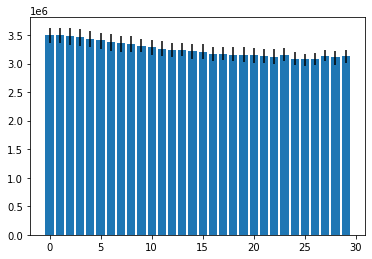

In [4]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.ensemble import ExtraTreesRegressor
def FeatureSelection(X,Y,nfolds=5,random_state=123):
    XX = X.values
    n_iter = 30
    cvmeanMAE = np.zeros(n_iter)
    cvminMAE = np.zeros(n_iter)
    cvmaxMAE = np.zeros(n_iter)
    cols = X.columns
    remaining_cols = []
    cvsplit = KFold(n_splits=nfolds, shuffle=True, random_state=random_state)
    for i in range(n_iter):
        print("Variable selection step " + str(i + 1) + " - " + str(XX.shape[1]) + " features remaining")
        rf = ExtraTreesRegressor(max_features=XX.shape[1], min_samples_leaf=1, n_estimators=1000)
        cv = cross_validate(estimator=rf, X=XX, y=Y, cv=cvsplit, n_jobs=5,
                            scoring="neg_mean_absolute_error")
        cvmeanMAE[i] = np.mean(-cv["test_score"])
        cvminMAE[i] = np.min(-cv["test_score"])
        cvmaxMAE[i] = np.max(-cv["test_score"])
        rf.fit(XX, Y)
        varimp = rf.feature_importances_
        ind = np.argsort(varimp)[5:]
        XX = XX[:, ind]
        cols = cols[ind]
        remaining_cols.append(cols)
    res = {"remaining_cols" : remaining_cols,
           "cvmeanMAE" : cvmeanMAE,
           "cvminMAE" : cvminMAE,
           "cvmaxMAE" : cvmaxMAE}
    return res

tmp = FeatureSelection(Xtrain, Ytrain)
from matplotlib import pyplot
pyplot.bar(np.arange(len(tmp["cvmeanMAE"])),height=tmp["cvmeanMAE"],
           yerr=np.concatenate([(tmp["cvmeanMAE"]-tmp["cvminMAE"]).reshape(-1,1),
                                (tmp["cvmaxMAE"]-tmp["cvmeanMAE"]).reshape(-1,1)],axis=1).T)

It can be seen that the MAE slowly decreases as the number of feature selection steps increases, until a number of steps around 25, after which it starts to increase again. Below are given the remaining columns when I ran it for the first time.

In [9]:
sel_cols = ['S1_max', 'S10_Q75', 'S3_Q50', 'S1_sumNA', 'S3_Q1', 'S3_max', 'S9_std',
       'S6_Q5', 'S7_Q1', 'S10_Q95', 'S5_Q90', 'S2_Q5', 'S5_Q5', 'S6_Q10',
       'S7_Q50', 'S1_Q95', 'S3_Q75', 'S5_Q10', 'S8_Q99', 'S4_Q95', 'S3_sumNA',
       'S7_Q90', 'S8_Q50', 'S6_Q90', 'S10_Q90', 'S2_sumNA', 'S4_Q99', 'S2_Q75',
       'S9_Q90', 'S9_Q25', 'S1_Q99', 'S6_Q1', 'S1_Q5', 'S7_Q99', 'S3_Q5',
       'S3_Q95', 'S5_Q99', 'S4_Q1', 'S9_Q50', 'S2_std', 'S1_Q75', 'S2_Q50',
       'S7_Q5', 'S10_Q25', 'S5_sumNA', 'S8_Q5', 'S10_Q1']

We can now select these features and evaluate the former algorithms again. As previously, the best results were obtained using ExtraTrees (here with max_features = 47 and min_samples_leaf = 1).

In [10]:
Xtrain = Xtrain[sel_cols]
Xtest = Xtest[sel_cols]
ET = ExtraTreesRegressor(max_features=47,min_samples_leaf=1,n_estimators=1000)
ET.fit(Xtrain, Ytrain)
pred = ET.predict(Xtest)
mae = np.mean(np.abs(Ytest-pred))
print(mae)
R2 = np.corrcoef(pred,Ytest)[0,1]**2
print(R2)

2958546.903552
0.8712721750914273


The feature selection procedure led to a further improvement of the results. Using only the selected features, the previous algorithms (RandomForest and boosting algorithms) were compared to ExtraTrees again, but ExtraTrees still gave the best results (this might be biased at this point since ExtraTrees was used to select the features). At this point, the best MAE value obtained on the test sample equals 2.9 * 10^6.

## Neural networks

I then switched to neural networks. I first tried out on the full set of variables, but could not get a satisfying performance. Trying again on the selected features gave much better results. A class implementing all the required steps for the training of the network and for predicting the response is given below. Those steps namely include proper scaling of the predictors and response and two callbacks:
- ModelCheckpoint, which enables us to save a fitted model at a given epoch when its score on the validation step beats the   previously obtained optimal validation score (this way, we only keep the best model on the validation sample, which helps   preventing overfitting)
- ReduceLROnPlateau, which automatically multiplies by 0.5 the current value of the learning rate if no improvement on the     validation score is observed during 20 successive epochs.

The arguments of the Network class are the following :
- file : name of the file to which will be saved the network by the ModelCheckpoint callback, each time an improvement is     observed on the validation set
- nval : size of the validation set
- epochs : number of epochs
- batch_size : batch size used for training the network.

In [12]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
class Network:
    def __init__(self,file,nval=500,nepochs=300,batch_size=64):
        self.nval = nval
        self.nepochs = nepochs
        self.batch_size = batch_size
        self.file = file
    def __build_model__(self,input_shape):
        net = keras.models.Sequential([
            keras.layers.Input(shape=input_shape),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dense(512, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(1, activation="linear")
        ])
        return net
    def fit(self,X,Y):
        Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=self.nval)
        scaler = StandardScaler()
        scaler.fit(Xtrain)
        Xtrain_sc = scaler.transform(Xtrain)
        Xval_sc = scaler.transform(Xval)
        my = np.mean(Ytrain)
        sy = np.std(Ytrain)
        Ytrain_sc = (Ytrain - my) / sy
        Yval_sc = (Yval - my) / sy
        net = self.__build_model__(X.shape[1])
        checkpoint = keras.callbacks.ModelCheckpoint(self.file,monitor="val_loss",
                                                     save_best_only=True,mode="min",
                                                     verbose=1)
        lr_callback = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=20)
        net.compile(loss="mean_absolute_error", optimizer=keras.optimizers.Nadam(learning_rate=0.001))
        fitted = net.fit(x=Xtrain_sc, y=Ytrain_sc, batch_size=self.batch_size, 
                         epochs=self.nepochs, verbose=1,
                         callbacks=[lr_callback, checkpoint], 
                         validation_data=(Xval_sc, Yval_sc))
        net = keras.models.load_model(self.file)
        fitted = {"net" : net, "scaler" : scaler, "my" : my, "sy" : sy}
        self.fitted = fitted
    def predict(self,Xtest):
        fitted = self.fitted
        net = fitted["net"]
        scaler = fitted["scaler"]
        my = fitted["my"]
        sy = fitted["sy"]
        pred = net.predict(scaler.transform(Xtest))[:,0]*sy+my
        return pred

The network architecture used in the __build_model__ function is the most performing one, among a great number of architectures I compared. The network can now be trained on the training set and evaluated on the test set.

In [13]:
net = Network(file=path+"/tmp_fitted_network.h5",nval=500,nepochs=300,batch_size=64)
net.fit(Xtrain,Ytrain)
pred = net.predict(Xtest)
mae = np.mean(np.abs(Ytest-pred))
print(mae)
R2 = np.corrcoef(Ytest,pred)[0,1]**2
print(R2)

Epoch 1/300
47/54 [=========================>....] - ETA: 0s - loss: 0.7183
Epoch 00001: val_loss improved from inf to 0.57140, saving model to C:/Users/Florian/Documents/PycharmProjects/Volcanoes\tmp_fitted_network.h5
54/54 [==============================] - 1s 9ms/step - loss: 0.7031 - val_loss: 0.5714 - lr: 0.0010
Epoch 2/300
53/54 [============================>.] - ETA: 0s - loss: 0.5753
Epoch 00002: val_loss improved from 0.57140 to 0.53388, saving model to C:/Users/Florian/Documents/PycharmProjects/Volcanoes\tmp_fitted_network.h5
54/54 [==============================] - 0s 7ms/step - loss: 0.5744 - val_loss: 0.5339 - lr: 0.0010
Epoch 3/300
50/54 [==========================>...] - ETA: 0s - loss: 0.5121
Epoch 00003: val_loss improved from 0.53388 to 0.46899, saving model to C:/Users/Florian/Documents/PycharmProjects/Volcanoes\tmp_fitted_network.h5
54/54 [==============================] - 0s 7ms/step - loss: 0.5114 - val_loss: 0.4690 - lr: 0.0010
Epoch 4/300
44/54 [================

48/54 [=========================>....] - ETA: 0s - loss: 0.1541
Epoch 00064: val_loss did not improve from 0.19468
54/54 [==============================] - 0s 5ms/step - loss: 0.1528 - val_loss: 0.1991 - lr: 0.0010
Epoch 65/300
48/54 [=========================>....] - ETA: 0s - loss: 0.1608
Epoch 00065: val_loss did not improve from 0.19468
54/54 [==============================] - 0s 6ms/step - loss: 0.1593 - val_loss: 0.2112 - lr: 0.0010
Epoch 66/300
49/54 [==========================>...] - ETA: 0s - loss: 0.1634
Epoch 00066: val_loss did not improve from 0.19468
54/54 [==============================] - 0s 6ms/step - loss: 0.1628 - val_loss: 0.2170 - lr: 0.0010
Epoch 67/300
48/54 [=========================>....] - ETA: 0s - loss: 0.1509
Epoch 00067: val_loss improved from 0.19468 to 0.19039, saving model to C:/Users/Florian/Documents/PycharmProjects/Volcanoes\tmp_fitted_network.h5
54/54 [==============================] - 0s 6ms/step - loss: 0.1514 - val_loss: 0.1904 - lr: 0.0010
Epoch

Epoch 98/300
51/54 [===========================>..] - ETA: 0s - loss: 0.1313
Epoch 00098: val_loss did not improve from 0.18227
54/54 [==============================] - 0s 6ms/step - loss: 0.1317 - val_loss: 0.1885 - lr: 0.0010
Epoch 99/300
51/54 [===========================>..] - ETA: 0s - loss: 0.1272
Epoch 00099: val_loss did not improve from 0.18227
54/54 [==============================] - 0s 6ms/step - loss: 0.1273 - val_loss: 0.2027 - lr: 0.0010
Epoch 100/300
51/54 [===========================>..] - ETA: 0s - loss: 0.1235
Epoch 00100: val_loss improved from 0.18227 to 0.18172, saving model to C:/Users/Florian/Documents/PycharmProjects/Volcanoes\tmp_fitted_network.h5
54/54 [==============================] - 0s 7ms/step - loss: 0.1240 - val_loss: 0.1817 - lr: 0.0010
Epoch 101/300
51/54 [===========================>..] - ETA: 0s - loss: 0.1293
Epoch 00101: val_loss did not improve from 0.18172
54/54 [==============================] - 0s 6ms/step - loss: 0.1287 - val_loss: 0.1885 - l

Epoch 165/300
47/54 [=========================>....] - ETA: 0s - loss: 0.0837
Epoch 00165: val_loss did not improve from 0.15235
54/54 [==============================] - 0s 5ms/step - loss: 0.0838 - val_loss: 0.1570 - lr: 5.0000e-04
Epoch 166/300
46/54 [========================>.....] - ETA: 0s - loss: 0.0860
Epoch 00166: val_loss did not improve from 0.15235
54/54 [==============================] - 0s 6ms/step - loss: 0.0863 - val_loss: 0.1562 - lr: 5.0000e-04
Epoch 167/300
47/54 [=========================>....] - ETA: 0s - loss: 0.0854
Epoch 00167: val_loss did not improve from 0.15235
54/54 [==============================] - 0s 6ms/step - loss: 0.0844 - val_loss: 0.1588 - lr: 5.0000e-04
Epoch 168/300
54/54 [==============================] - ETA: 0s - loss: 0.0857
Epoch 00168: val_loss did not improve from 0.15235
54/54 [==============================] - 0s 6ms/step - loss: 0.0857 - val_loss: 0.1525 - lr: 5.0000e-04
Epoch 169/300
49/54 [==========================>...] - ETA: 0s - los

Epoch 199/300
47/54 [=========================>....] - ETA: 0s - loss: 0.0823
Epoch 00199: val_loss did not improve from 0.14682
54/54 [==============================] - 0s 7ms/step - loss: 0.0821 - val_loss: 0.1573 - lr: 5.0000e-04
Epoch 200/300
49/54 [==========================>...] - ETA: 0s - loss: 0.0825
Epoch 00200: val_loss did not improve from 0.14682
54/54 [==============================] - 0s 6ms/step - loss: 0.0826 - val_loss: 0.1537 - lr: 5.0000e-04
Epoch 201/300
48/54 [=========================>....] - ETA: 0s - loss: 0.0829
Epoch 00201: val_loss did not improve from 0.14682
54/54 [==============================] - 0s 6ms/step - loss: 0.0827 - val_loss: 0.1508 - lr: 5.0000e-04
Epoch 202/300
45/54 [========================>.....] - ETA: 0s - loss: 0.0801
Epoch 00202: val_loss did not improve from 0.14682
54/54 [==============================] - 0s 7ms/step - loss: 0.0793 - val_loss: 0.1510 - lr: 5.0000e-04
Epoch 203/300
49/54 [==========================>...] - ETA: 0s - los

Epoch 233/300
54/54 [==============================] - ETA: 0s - loss: 0.0691
Epoch 00233: val_loss did not improve from 0.14062
54/54 [==============================] - 0s 6ms/step - loss: 0.0691 - val_loss: 0.1480 - lr: 2.5000e-04
Epoch 234/300
54/54 [==============================] - ETA: 0s - loss: 0.0683
Epoch 00234: val_loss did not improve from 0.14062
54/54 [==============================] - 0s 6ms/step - loss: 0.0683 - val_loss: 0.1513 - lr: 2.5000e-04
Epoch 235/300
52/54 [===========================>..] - ETA: 0s - loss: 0.0693
Epoch 00235: val_loss did not improve from 0.14062
54/54 [==============================] - 0s 6ms/step - loss: 0.0691 - val_loss: 0.1470 - lr: 2.5000e-04
Epoch 236/300
50/54 [==========================>...] - ETA: 0s - loss: 0.0690
Epoch 00236: val_loss did not improve from 0.14062
54/54 [==============================] - 0s 6ms/step - loss: 0.0691 - val_loss: 0.1472 - lr: 2.5000e-04
Epoch 237/300
47/54 [=========================>....] - ETA: 0s - los

A final MAE value of 2.16 * 10^6 is obtained. Much better than the best ExtraTrees performance !
The network can finally be trained on the full sample, and the values for the test sample can be predicted.

In [14]:
X = pd.read_csv(path+"/X.csv",sep=";",index_col=0)
Y = pd.read_csv(path+"/Y.csv",sep=";",index_col=0)
Xtest = pd.read_csv(path+"/Xtest.csv",sep=";",index_col=0)
segment_id = Xtest.index
X = X[sel_cols]
Xtest = Xtest[sel_cols]
net = Network(file=path+"/fitted_network.h5",nval=500,nepochs=300,batch_size=64)
net.fit(X,Y["time_to_eruption"])
pred = net.predict(Xtest)
res = pd.DataFrame({"segment_id" : segment_id, "time_to_eruption" : pred})
res.to_csv(path+"/prediction_test.csv",sep=",",columns=res.columns,index=False)

Epoch 1/300
58/62 [===========================>..] - ETA: 0s - loss: 0.6901
Epoch 00001: val_loss improved from inf to 0.59652, saving model to C:/Users/Florian/Documents/PycharmProjects/Volcanoes\fitted_network.h5
62/62 [==============================] - 1s 8ms/step - loss: 0.6826 - val_loss: 0.5965 - lr: 0.0010
Epoch 2/300
51/62 [=======================>......] - ETA: 0s - loss: 0.5526
Epoch 00002: val_loss improved from 0.59652 to 0.50587, saving model to C:/Users/Florian/Documents/PycharmProjects/Volcanoes\fitted_network.h5
62/62 [==============================] - 0s 7ms/step - loss: 0.5422 - val_loss: 0.5059 - lr: 0.0010
Epoch 3/300
58/62 [===========================>..] - ETA: 0s - loss: 0.4655
Epoch 00003: val_loss improved from 0.50587 to 0.49121, saving model to C:/Users/Florian/Documents/PycharmProjects/Volcanoes\fitted_network.h5
62/62 [==============================] - 0s 7ms/step - loss: 0.4668 - val_loss: 0.4912 - lr: 0.0010
Epoch 4/300
55/62 [=========================>..

62/62 [==============================] - 0s 7ms/step - loss: 0.2083 - val_loss: 0.2292 - lr: 0.0010
Epoch 32/300
52/62 [========================>.....] - ETA: 0s - loss: 0.2011
Epoch 00032: val_loss did not improve from 0.22925
62/62 [==============================] - 0s 6ms/step - loss: 0.2032 - val_loss: 0.2457 - lr: 0.0010
Epoch 33/300
58/62 [===========================>..] - ETA: 0s - loss: 0.2029
Epoch 00033: val_loss did not improve from 0.22925
62/62 [==============================] - 0s 6ms/step - loss: 0.2022 - val_loss: 0.2461 - lr: 0.0010
Epoch 34/300
57/62 [==========================>...] - ETA: 0s - loss: 0.2064
Epoch 00034: val_loss did not improve from 0.22925
62/62 [==============================] - 0s 6ms/step - loss: 0.2069 - val_loss: 0.2421 - lr: 0.0010
Epoch 35/300
54/62 [=========================>....] - ETA: 0s - loss: 0.1967
Epoch 00035: val_loss did not improve from 0.22925
62/62 [==============================] - 0s 6ms/step - loss: 0.1986 - val_loss: 0.3672 -

Epoch 66/300
54/62 [=========================>....] - ETA: 0s - loss: 0.1464
Epoch 00066: val_loss did not improve from 0.19222
62/62 [==============================] - 0s 6ms/step - loss: 0.1500 - val_loss: 0.2112 - lr: 0.0010
Epoch 67/300
57/62 [==========================>...] - ETA: 0s - loss: 0.1579
Epoch 00067: val_loss did not improve from 0.19222
62/62 [==============================] - 0s 7ms/step - loss: 0.1584 - val_loss: 0.2064 - lr: 0.0010
Epoch 68/300
53/62 [========================>.....] - ETA: 0s - loss: 0.1541
Epoch 00068: val_loss did not improve from 0.19222
62/62 [==============================] - 0s 7ms/step - loss: 0.1543 - val_loss: 0.2203 - lr: 0.0010
Epoch 69/300
60/62 [============================>.] - ETA: 0s - loss: 0.1463
Epoch 00069: val_loss did not improve from 0.19222
62/62 [==============================] - 0s 7ms/step - loss: 0.1465 - val_loss: 0.2052 - lr: 0.0010
Epoch 70/300
59/62 [===========================>..] - ETA: 0s - loss: 0.1495
Epoch 00070

Epoch 100/300
57/62 [==========================>...] - ETA: 0s - loss: 0.1308
Epoch 00100: val_loss improved from 0.17929 to 0.17720, saving model to C:/Users/Florian/Documents/PycharmProjects/Volcanoes\fitted_network.h5
62/62 [==============================] - 0s 6ms/step - loss: 0.1308 - val_loss: 0.1772 - lr: 0.0010
Epoch 101/300
60/62 [============================>.] - ETA: 0s - loss: 0.1327
Epoch 00101: val_loss did not improve from 0.17720
62/62 [==============================] - 0s 6ms/step - loss: 0.1320 - val_loss: 0.1794 - lr: 0.0010
Epoch 102/300
57/62 [==========================>...] - ETA: 0s - loss: 0.1278
Epoch 00102: val_loss did not improve from 0.17720
62/62 [==============================] - 0s 5ms/step - loss: 0.1286 - val_loss: 0.1942 - lr: 0.0010
Epoch 103/300
59/62 [===========================>..] - ETA: 0s - loss: 0.1322
Epoch 00103: val_loss did not improve from 0.17720
62/62 [==============================] - 0s 5ms/step - loss: 0.1327 - val_loss: 0.1832 - lr:

Epoch 134/300
54/62 [=========================>....] - ETA: 0s - loss: 0.1128
Epoch 00134: val_loss did not improve from 0.16472
62/62 [==============================] - 0s 7ms/step - loss: 0.1135 - val_loss: 0.1859 - lr: 0.0010
Epoch 135/300
60/62 [============================>.] - ETA: 0s - loss: 0.1184
Epoch 00135: val_loss did not improve from 0.16472
62/62 [==============================] - 0s 6ms/step - loss: 0.1186 - val_loss: 0.1700 - lr: 0.0010
Epoch 136/300
53/62 [========================>.....] - ETA: 0s - loss: 0.1150
Epoch 00136: val_loss did not improve from 0.16472
62/62 [==============================] - 0s 6ms/step - loss: 0.1162 - val_loss: 0.2014 - lr: 0.0010
Epoch 137/300
56/62 [==========================>...] - ETA: 0s - loss: 0.1161
Epoch 00137: val_loss did not improve from 0.16472
62/62 [==============================] - 0s 6ms/step - loss: 0.1169 - val_loss: 0.1738 - lr: 0.0010
Epoch 138/300
54/62 [=========================>....] - ETA: 0s - loss: 0.1131
Epoch 

Epoch 168/300
52/62 [========================>.....] - ETA: 0s - loss: 0.0862
Epoch 00168: val_loss did not improve from 0.15405
62/62 [==============================] - 0s 6ms/step - loss: 0.0859 - val_loss: 0.1627 - lr: 5.0000e-04
Epoch 169/300
55/62 [=========================>....] - ETA: 0s - loss: 0.0817
Epoch 00169: val_loss did not improve from 0.15405
62/62 [==============================] - 0s 6ms/step - loss: 0.0822 - val_loss: 0.1692 - lr: 5.0000e-04
Epoch 170/300
57/62 [==========================>...] - ETA: 0s - loss: 0.0877
Epoch 00170: val_loss did not improve from 0.15405
62/62 [==============================] - 0s 6ms/step - loss: 0.0878 - val_loss: 0.1608 - lr: 5.0000e-04
Epoch 171/300
61/62 [============================>.] - ETA: 0s - loss: 0.0879
Epoch 00171: val_loss did not improve from 0.15405
62/62 [==============================] - 0s 6ms/step - loss: 0.0879 - val_loss: 0.1555 - lr: 5.0000e-04
Epoch 172/300
62/62 [==============================] - ETA: 0s - los

Epoch 203/300
54/62 [=========================>....] - ETA: 0s - loss: 0.0721
Epoch 00203: val_loss did not improve from 0.15392
62/62 [==============================] - 0s 6ms/step - loss: 0.0718 - val_loss: 0.1604 - lr: 2.5000e-04
Epoch 204/300
57/62 [==========================>...] - ETA: 0s - loss: 0.0718
Epoch 00204: val_loss did not improve from 0.15392
62/62 [==============================] - 0s 6ms/step - loss: 0.0716 - val_loss: 0.1686 - lr: 2.5000e-04
Epoch 205/300
59/62 [===========================>..] - ETA: 0s - loss: 0.0690
Epoch 00205: val_loss did not improve from 0.15392
62/62 [==============================] - 0s 6ms/step - loss: 0.0689 - val_loss: 0.1654 - lr: 2.5000e-04
Epoch 206/300
59/62 [===========================>..] - ETA: 0s - loss: 0.0701
Epoch 00206: val_loss did not improve from 0.15392
62/62 [==============================] - 0s 5ms/step - loss: 0.0696 - val_loss: 0.1608 - lr: 2.5000e-04
Epoch 207/300
55/62 [=========================>....] - ETA: 0s - los

56/62 [==========================>...] - ETA: 0s - loss: 0.0594
Epoch 00273: val_loss did not improve from 0.15392
62/62 [==============================] - 0s 6ms/step - loss: 0.0590 - val_loss: 0.1565 - lr: 1.5625e-05
Epoch 274/300
57/62 [==========================>...] - ETA: 0s - loss: 0.0605
Epoch 00274: val_loss did not improve from 0.15392
62/62 [==============================] - 0s 6ms/step - loss: 0.0603 - val_loss: 0.1564 - lr: 1.5625e-05
Epoch 275/300
56/62 [==========================>...] - ETA: 0s - loss: 0.0601
Epoch 00275: val_loss did not improve from 0.15392
62/62 [==============================] - 0s 6ms/step - loss: 0.0601 - val_loss: 0.1565 - lr: 1.5625e-05
Epoch 276/300
56/62 [==========================>...] - ETA: 0s - loss: 0.0612
Epoch 00276: val_loss did not improve from 0.15392
62/62 [==============================] - 0s 6ms/step - loss: 0.0608 - val_loss: 0.1564 - lr: 1.5625e-05
Epoch 277/300
57/62 [==========================>...] - ETA: 0s - loss: 0.0601
Epoc